### Imports and utils

In [1]:
import re, json, os, yaml
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Extract statistics from Timeloop output files
def extract_tl_stats(file_path):
  with open(file_path, "r") as f:
    stats = f.read()

    res = re.findall(r'Utilization:\s(\d+.\d+)\s', stats, re.DOTALL)
    utilization = float(res[0])

    res = re.findall(r'Total\s+= (\d+.\d+)\s', stats, re.DOTALL)
    efficiency = float(res[0])

    res = re.findall(r'Cycles:\s(\d+)', stats, re.DOTALL)
    cycles = int(res[0])

    res = re.findall(r'Energy:\s(\d+.\d+)\suJ', stats, re.DOTALL)
    energy = float(res[0])

    f.close()

  return utilization, efficiency, cycles, energy

# Generate dataframe considering results for each workload and layer-workload lookups
def generate_dataframe(folder, method, network, exclude=[], end=None):
  lookup_file = '../workloads/lookups.yaml'
  with open(lookup_file, 'r') as f:
    lookup_yaml = yaml.safe_load(f)
      
  layer_workload_lookup = lookup_yaml['layer_workload_lookups'][network]
  network_name = lookup_yaml['network_names'][network]

  workload_ids = sorted(list(set(layer_workload_lookup)))
  
  missing = []
  total_energy = total_latency = 0
  for w in layer_workload_lookup[:end]:
    stats_file = f'./{folder}/{network}/{str(w).zfill(len(str(len(workload_ids))))}/timeloop-model.stats.txt'
    if not os.path.isfile(stats_file) :
      print('gift', method, network)
      missing.append((network, w))
      continue
    if (network, w) in exclude:
      continue
    utilization, efficiency, cycles, energy = extract_tl_stats(stats_file)
    #print(method, network, w, utilization, efficiency, cycles, energy)
    total_energy += energy
    total_latency += cycles

  with open(f'./{folder}/{network}/runtime.json', 'r') as runtime_file:
    runtime_dict = json.load(runtime_file)
    runtime = runtime_dict['runtime']
  
  df_dict = {
    'Method': method,
    'Network': network_name,
    'Energy [uJ]': total_energy,
    'Cycles': total_latency,
    'EDP': total_energy*total_latency,
    'Runtime [s]': runtime,
  }

  return missing, pd.DataFrame(df_dict, index=[0])

# Plot Styling
font_size = 8
_new_black = '#373737'
color_grid = '#F1F5B7'
color1 = '#EBF095'
color2 = '#DEE600'
color3 = '#CBCD00'
color4 = '#B8B400'
sns.set_theme(style='ticks', font_scale=0.75, rc={
    'font.family': 'serif',
    'font.serif': ['Linux Libertine O'],
    'svg.fonttype': 'none',
    'text.usetex': False,
    'pdf.fonttype': 42,
    'ps.fonttype': 42,
    'font.size': font_size,
    'axes.labelsize': font_size,
    'axes.titlesize': font_size,
    'axes.labelpad': 2,
    'axes.linewidth': 1,
    'axes.titlepad': 4,
    'lines.linewidth': 1,
    'legend.fontsize': font_size,
    'legend.title_fontsize': font_size,
    'xtick.labelsize': font_size,
    'ytick.labelsize': font_size,
    'xtick.major.size': 2,
    'xtick.major.pad': 1,
    'xtick.major.width': 1,
    'ytick.major.size': 2,
    'ytick.major.pad': 1,
    'ytick.major.width': 1,
    'xtick.minor.size': 2,
    'xtick.minor.pad': 1,
    'xtick.minor.width': 1,
    'ytick.minor.size': 2,
    'ytick.minor.pad': 1,
    'ytick.minor.width': 1,
    'text.color': _new_black,
    'patch.edgecolor': _new_black,
    'patch.force_edgecolor': False,
    'hatch.color': 'white',
    'axes.edgecolor': _new_black,
    'axes.labelcolor': _new_black,
    'xtick.color': _new_black,
    'ytick.color': _new_black,
    'figure.figsize': (3.34,1.5),
    'axes.grid' : True,
    'grid.color': color_grid,
})

### EDP Comparison

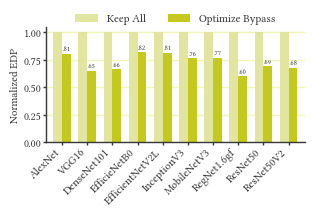

In [2]:
lookup_file = '../workloads/lookups.yaml'
with open(lookup_file, 'r') as f:
    lookup_yaml = yaml.safe_load(f)

plot_ref = False # Set true to plot reference results
ref_sfx = '-ref' if plot_ref else ''

data = pd.DataFrame()
networks = lookup_yaml['networks']
for network in networks:
    _, lemon_data = generate_dataframe('results'+ref_sfx+'/lemon', 'Keep All', network)
    _, lemon_ob_data = generate_dataframe('results'+ref_sfx+'/lemon_ob', 'Optimize Bypass', network)
    data = pd.concat([data, lemon_data, lemon_ob_data], ignore_index=True)

data['Normalized EDP'] = data.groupby('Network')['EDP'].transform(lambda x: x / x.iloc[0])
g = sns.barplot(data, x='Network', y='Normalized EDP', hue='Method', width=0.7, palette=[color1, color2])
_ = plt.xticks(rotation=45, ha='right')
g.margins(x=0.03)

bcl = len(networks)
for i, p in enumerate(g.patches):
    if p.get_height() < 1.0:
        g.annotate(f'{p.get_height():.2f}'.lstrip('0'), (p.get_x() + p.get_width() / 2., np.min([p.get_height(), g.get_ylim()[1]])), 
                    ha = 'center', va = 'center', xytext = (0.1, 3.3), textcoords = 'offset points', fontsize=5)
    

g.legend()
sns.move_legend(g, "upper center", bbox_to_anchor=(0.5, 1.20), ncol=2, title=None, frameon=False)
    
_ = g.set(xlabel=None)
sns.despine()

#plt.savefig('bypass.pdf', bbox_inches='tight', pad_inches = 0)

### Runtime Comparison

             Method          Network  Energy [uJ]    Cycles           EDP   
0          Keep All          AlexNet      6193.87   4309737  2.669395e+10  \
1   Optimize Bypass          AlexNet      5467.55   3936681  2.152400e+10   
2          Keep All            VGG16     49723.05  22811113  1.134238e+12   
3   Optimize Bypass            VGG16     33591.46  21994647  7.388323e+11   
4          Keep All      DenseNet101     21328.85   6310103  1.345872e+11   
5   Optimize Bypass      DenseNet101     14312.66   6226615  8.911942e+10   
6          Keep All     EfficieNetB0      1717.04    704401  1.209485e+09   
7   Optimize Bypass     EfficieNetB0      1569.44    630492  9.895194e+08   
8          Keep All  EfficientNetV2L    165609.16  55894934  9.256713e+12   
9   Optimize Bypass  EfficientNetV2L    135005.60  55794636  7.532588e+12   
10         Keep All      InceptionV3     18831.97   5987656  1.127594e+11   
11  Optimize Bypass      InceptionV3     14717.41   5844069  8.600956e+10   

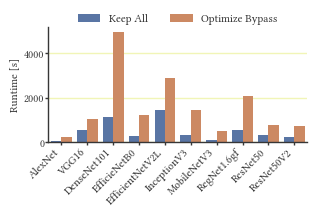

In [3]:
lookup_file = '../workloads/lookups.yaml'
with open(lookup_file, 'r') as f:
    lookup_yaml = yaml.safe_load(f)

data = pd.DataFrame()
for network in lookup_yaml['networks']:
    gamma_missing, gamma_data = generate_dataframe('results'+ref_sfx+'/lemon', 'Keep All', network, end=None)
    lemon_missing, lemon_data = generate_dataframe('results'+ref_sfx+'/lemon_ob', 'Optimize Bypass', network, end=None, exclude=gamma_missing)
    data = pd.concat([data, gamma_data, lemon_data], ignore_index=True)

data['Normalized Runtime'] = data.groupby('Network')['Runtime [s]'].transform(lambda x: x/x.max())
print(data)

g = sns.barplot(data, x='Network', y='Runtime [s]', hue='Method')
_ = plt.xticks(rotation=45, ha='right')
sns.move_legend(g, "upper center", bbox_to_anchor=(0.5, 1.2), ncol=2, title=None, frameon=False)
sns.despine()
_ = g.set_xlabel(None)